In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
###Data just limited to MLS games for now, reddit data really limited as well
### Comments only go back to 2023-07
# nashville_comments['Year-Month'].min()

In [3]:
# Comments with sentiment
nashville_comments = pd.read_csv('nashvillesc_comments.csv')
nashville_comments.head()

,Unnamed: 0,Post ID,Comment Author,Comment Body,Comment Score,Created,Sentiment
0,0,1i87o7p,Whiskey615,Didn’t really play much last season in Spain’s...,11,2025-01-23 16:59:16,Neutral
1,1,1i87o7p,Swaggron,"Ok, but what will we chant when he blocks a shot?",3,2025-01-23 18:04:38,Neutral
2,2,1i87o7p,Jindro41,I come in peace as someone who's known Brian f...,3,2025-01-24 02:36:33,Positive
3,3,1i87o7p,DrEvilEngineer,I know it's exiciting to sign a player with ex...,1,2025-01-23 21:51:01,Neutral
4,4,1i87o7p,DrEvilEngineer,[Greenock Morton](https://en.wikipedia.org/wik...,2,2025-01-23 21:55:31,Neutral


In [4]:
# Home Game Attendance 
attendance_df= pd.read_csv('nashville_attendance.csv')
attendance_df = attendance_df[attendance_df['Stadium'] == 'Geodis Park']
attendance_df.head()

# we need to concat Match Data and Season

,Match Date,Home Team,Home Team Score,Away Team,Away Team Score,Stadium,Attendance,Season
0,25-Feb,Nashville SC,0,New York Red Bulls,0,Geodis Park,30109.0,2024
2,10-Mar,Nashville SC,2,LA Galaxy,2,Geodis Park,28316.0,2024
3,16-Mar,Nashville SC,2,Charlotte FC,1,Geodis Park,28008.0,2024
5,30-Mar,Nashville SC,2,Columbus Crew,2,Geodis Park,28613.0,2024
6,6-Apr,Nashville SC,1,Philadelphia Union,2,Geodis Park,27739.0,2024


In [5]:
#Converting dates 
nashville_comments['Created'] = pd.to_datetime(nashville_comments['Created'])
nashville_comments['Year-Month'] = nashville_comments['Created'].dt.strftime('%Y-%m')

attendance_df['Match Date'] = pd.to_datetime(attendance_df['Match Date'], format='%d-%b')
attendance_df['Year-Month'] = attendance_df['Season'].astype(str) + '-' + attendance_df['Match Date'].dt.strftime('%m')

#Just home games
attendance_df = attendance_df[attendance_df['Stadium'] == 'Geodis Park']

### Data engineering ### booleans 
attendance_df['Wins'] = (attendance_df['Home Team Score'] > attendance_df['Away Team Score']).astype(int)
attendance_df['Draws'] = (attendance_df['Home Team Score'] == attendance_df['Away Team Score']).astype(int)

#team performance pts 3 for win , 1 for draw, 0 for loss
attendance_df['Performance Score'] = (attendance_df['Wins'] * 3) + (attendance_df['Draws'] * 1)

#Group performance by date amd take mean
monthly_performance = attendance_df.groupby('Year-Month').agg(
    Total_Performance_Score=('Performance Score', 'sum'),
    Matches_Played=('Wins', 'count') 
).reset_index()
monthly_performance['Avg_Performance_Score'] = monthly_performance['Total_Performance_Score'] / monthly_performance['Matches_Played']

#Isolate +/- comments, get counts 
positive_comments = nashville_comments[nashville_comments['Sentiment'] == 'Positive'].groupby('Year-Month').size().rename('Positive Comments')
negative_comments = nashville_comments[nashville_comments['Sentiment'] == 'Negative'].groupby('Year-Month').size().rename('Negative Comments')
positive_negative_total = (positive_comments + negative_comments).rename('Total Sentiment Comments')

#Proportion of positive sentiment 
monthly_sentiment = pd.DataFrame({
    'Year-Month': positive_negative_total.index,
    'Positive Sentiment Proportion': (positive_comments / positive_negative_total)
}).reset_index(drop=True)

# #Proportion of negative sentiment 
# monthly_sentiment = pd.DataFrame({
#     'Year-Month': positive_negative_total.index,
#     'Positive Sentiment Proportion': (negative_comments / positive_negative_total)
# }).reset_index(drop=True)

#Average monthly attendance 
monthly_attendance = attendance_df.groupby('Year-Month')['Attendance'].mean().reset_index()

#merge the three vars with inner join, only dates for games played reflected 
merged_df = monthly_attendance.merge(monthly_sentiment, on='Year-Month', how='inner')
merged_df = merged_df.merge(monthly_performance, on='Year-Month', how='inner')

# Standardize the data (Z-score normalization)
# scaler = StandardScaler()
# merged_df[['Attendance', 'Positive Sentiment Proportion', 'Avg_Performance_Score']] = scaler.fit_transform(
#     merged_df[['Attendance', 'Positive Sentiment Proportion', 'Avg_Performance_Score']]
# )

#correlations
correlation = merged_df[['Attendance', 'Positive Sentiment Proportion', 'Avg_Performance_Score']].corr()


In [6]:
merged_df

,Year-Month,Attendance,Positive Sentiment Proportion,Total_Performance_Score,Matches_Played,Avg_Performance_Score
0,2023-07,30109.000000,0.364929,3,2,1.500000
1,2023-09,28096.500000,0.394309,2,2,1.000000
2,2023-10,26976.000000,0.254989,3,3,1.000000
3,2024-02,30109.000000,0.487713,1,1,1.000000
4,2024-03,28312.333333,0.339797,5,3,1.666667
5,2024-04,28361.500000,0.315650,1,2,0.500000
6,2024-05,28281.666667,0.498998,7,3,2.333333
7,2024-06,28871.333333,0.496241,3,3,1.000000
8,2024-07,29070.000000,0.345238,0,1,0.000000
9,2024-08,28876.000000,0.362924,0,1,0.000000


In [7]:
correlation

,Attendance,Positive Sentiment Proportion,Avg_Performance_Score
Attendance,1.000000,0.331248,-0.182771
Positive Sentiment Proportion,0.331248,1.000000,0.499441
Avg_Performance_Score,-0.182771,0.499441,1.000000


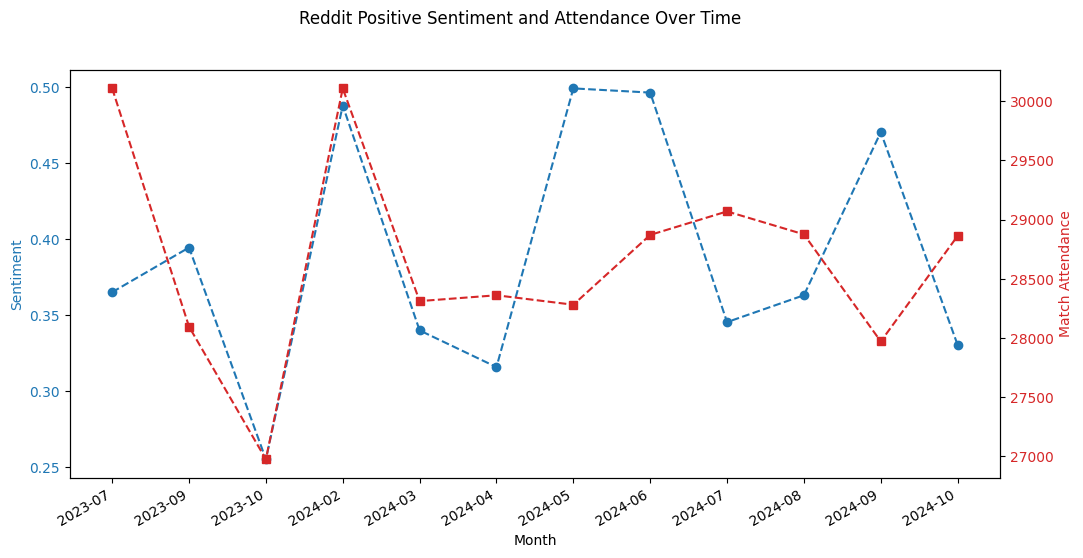

In [8]:
fig, ax1 = plt.subplots(figsize=(12, 6))

#Sentiment (+)
ax1.set_xlabel('Month')
ax1.set_ylabel('Sentiment', color='tab:blue')
ax1.plot(merged_df['Year-Month'], merged_df['Positive Sentiment Proportion'], color='tab:blue', marker='o', linestyle='dashed', label='Reddit Sentiment (+)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

#Attendance
ax2 = ax1.twinx()
ax2.set_ylabel('Match Attendance', color='tab:red')
ax2.plot(merged_df['Year-Month'], merged_df['Attendance'], color='tab:red', marker='s', linestyle='dashed', label='Match Attendance')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.suptitle('Reddit Positive Sentiment and Attendance Over Time')
fig.autofmt_xdate()
plt.show()


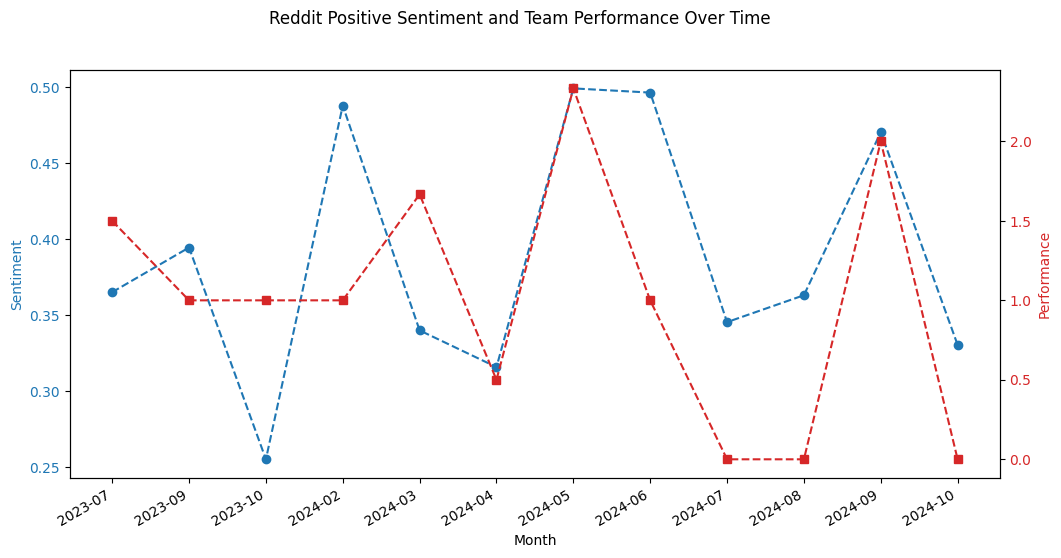

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 6))

#Sentiment (+)
ax1.set_xlabel('Month')
ax1.set_ylabel('Sentiment', color='tab:blue')
ax1.plot(merged_df['Year-Month'], merged_df['Positive Sentiment Proportion'], color='tab:blue', marker='o', linestyle='dashed', label='Reddit Sentiment (+)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

#Attendance
ax2 = ax1.twinx()
ax2.set_ylabel('Performance', color='tab:red')
ax2.plot(merged_df['Year-Month'], merged_df['Avg_Performance_Score'], color='tab:red', marker='s', linestyle='dashed', label='Team Performance')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.suptitle('Reddit Positive Sentiment and Team Performance Over Time')
fig.autofmt_xdate()
plt.show()
